In [1]:
from mplsoccer import Sbopen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import streamlit as st
from joblib import load
from db_connection import get_db
import torch
import torch.nn as nn
import torch.nn.functional as F
from sql_schemas import PlayingTimes, Competitions
from db_connection import get_db
from sqlalchemy import text
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define Pitch Zones


In [2]:
def get_pitch_zone(x, y):
    # Define horizontal zones (x-axis)
    if x < 40:
        horiz_zone = 'Defensive'
    elif x <= 80:
        horiz_zone = 'Middle'
    else:
        horiz_zone = 'Attacking'

    # Define vertical zones (y-axis)
    if y < 20:
        vert_zone = 'Right'
    elif y <= 60:
        vert_zone = 'Center'
    else:
        vert_zone = 'Left'
    
    return f"{horiz_zone} {vert_zone}"

# Apply function to create start and end zones

In [3]:
df_event = pd.read_csv('../../excel/event_df.csv')
track_df = pd.read_csv('../../excel/track_df.csv')

C:\Users\juras\AppData\Local\Temp\ipykernel_16080\3537398426.py:1: DtypeWarning: Columns (43,55,56,58,59,60,61,62,63,65,66,67,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_event = pd.read_csv('../../excel/event_df.csv')


In [4]:
df_event = df_event.dropna(subset=['x', 'y'])
df_event = df_event[~df_event[['x', 'y']].isin([float('inf'), float('-inf')]).any(axis=1)]
df_event.loc[df_event['end_x'].isna(), 'end_x'] = df_event['x']
df_event.loc[df_event['end_y'].isna(), 'end_y'] = df_event['y']

df_event['start_zone'] = df_event.apply(lambda row: get_pitch_zone(row['x'], row['y']), axis=1)
df_event['end_zone'] = df_event.apply(lambda row: get_pitch_zone(row['end_x'], row['end_y']), axis=1)

df_event["position_name"].unique()

position_map = {

    "Center Forward": "Striker",
    "Left Center Forward": "Striker",
    "Right Center Forward": "Striker",
    "Second Striker": "Striker",
    "Striker": "Striker",

    # --- Center Backs ---
    "Center Back": "Center Back",
    "Left Center Back": "Center Back",
    "Right Center Back": "Center Back",

    # --- Fullbacks & Wingbacks ---
    "Left Back": "Wide Back",
    "Right Back": "Wide Back",
    "Left Wing Back": "Wide Back",
    "Right Wing Back": "Wide Back",

    # --- Central Midfielders ---
    "Center Midfield": "Center Midfield",
    "Left Center Midfield": "Center Midfield",
    "Right Center Midfield": "Center Midfield",
    "Center Defensive Midfield": "Center Midfield",
    "Left Defensive Midfield": "Center Midfield",
    "Right Defensive Midfield": "Center Midfield",
    "Center Attacking Midfield": "Center Midfield",
    "Left Attacking Midfield": "Center Midfield",
    "Right Attacking Midfield": "Center Midfield",

    # --- Wide Midfielders / Wingers ---
    "Left Midfield": "Wide Midfield",
    "Right Midfield": "Wide Midfield",
    "Left Wing": "Wide Midfield",
    "Right Wing": "Wide Midfield",

    "Goalkeeper": "Goalkeeper",
}

df_event["pos_group"] = df_event["position_name"].map(position_map)

# Step 2: Compute Movement Features

In [5]:
df_event['distance'] = np.sqrt((df_event['x'] - df_event['end_x']) ** 2 + (df_event['y'] - df_event['end_y']) ** 2)
df_event['progression'] = df_event['end_x'] - df_event['x']
df_event['directness'] = np.where(df_event['distance'] != 0, df_event['progression'] / df_event['distance'], 0)
df_event['width_change'] = abs(df_event['end_y'] - df_event['y'])
#df_event['speed'] = np.where(df_event['duration'] != 0, df_event['distance'] / df_event['duration'], 0)
#df_event['distance_covered'] = np.sqrt((df_event['end_x'] - df_event['x']) ** 2 + (df_event['end_y'] - df_event['y']) ** 2)
#df_event['angle_change'] = np.arctan2(df_event['end_y'] - df_event['y'], df_event['end_x'] - df_event['x'])

Packing Metrics

In [6]:
id_pos = df_event.loc[:,['id', 'x', 'y', 'end_x', 'end_y']]
id_pos = id_pos.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
track_df_full = track_df.merge(id_pos, on='id', how='left')
track_df_full = track_df_full[track_df_full['actor']==False]
track_df_full['distance'] = np.sqrt((track_df_full['x'] - track_df_full['ball_x'])**2 + (track_df_full['y'] - track_df_full['ball_y'])**2)

# ball went behind the opponent
track_df_full['packing'] = (track_df_full['x'] > track_df_full['ball_x']) & (track_df_full['x'] < track_df_full['end_x'])


teammates_df = track_df_full[track_df_full['teammate'] == True]
teammates_df = teammates_df.rename(columns={'distance': 'teammate_distance'})

teammates_df['teammate_behind_ball'] = (teammates_df['x'] > teammates_df['ball_x'])

opponents_df = track_df_full[track_df_full['teammate'] == False]
opponents_df = opponents_df.rename(columns={'distance': 'opponent_distance'})

track_df_full['nearby_opponents'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==False)
track_df_full['nearby_teammates'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==True)


teammate_distance_min = teammates_df.groupby(['id'])['teammate_distance'].min().reset_index()
opponent_distance_min = opponents_df.groupby('id')['opponent_distance'].min().reset_index()

distance_count = track_df_full.groupby('id')['nearby_opponents'].sum().reset_index()
distance_count_teammates = track_df_full.groupby('id')['nearby_teammates'].sum().reset_index()
packing = opponents_df.groupby('id')['packing'].sum().reset_index()
teammate_forward = teammates_df.groupby('id')['teammate_behind_ball'].sum().reset_index()


df_event = df_event.merge(distance_count, on='id', how='left')
df_event = df_event.merge(distance_count_teammates, on='id', how='left')
df_event = df_event.merge(teammate_distance_min, on='id', how='left')
df_event = df_event.merge(opponent_distance_min, on='id', how='left')
df_event = df_event.merge(packing, on='id', how='left')
df_event = df_event.merge(teammate_forward, on='id', how='left')

## Heatmap

In [7]:
def make_heatmap(x, y, bins=(12,4), xrange=(0, 120), yrange=(0, 40)):
    heatmap, _, _ = np.histogram2d(
        x, y,
        bins=bins,
        range=[xrange, yrange]
    )
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) > 0 else heatmap
    return heatmap

In [8]:
player_name = pd.read_excel('../../excel/player_features.xlsx').loc[:,["player_id", "player_name", "minutes"]]

In [9]:
grouped = df_event.groupby('player_id')

heatmaps = []
ids = []

for player_id, group in grouped:
    # Make heatmap for this player
    h = make_heatmap(group["x"], abs(40-group["y"]))
    
    # Scale to 0-1 for this player
    h_min, h_max = h.min(), h.max()
    if h_max > h_min:  # avoid division by zero
        h = (h - h_min) / (h_max - h_min)
    else:
        h = np.zeros_like(h)  # if all values are the same
    if player_name.loc[player_name["player_id"] == player_id, "minutes"].values[0] > 500:
        heatmaps.append(h)
        ids.append(player_id)


normalized_heatmaps = []  # shape: (N, H, W)


for h in heatmaps:  # heatmaps.shape = (N, H, W)
    h_min, h_max = h.min(), h.max()
    if h_max > h_min:
        h_norm = (h - h_min) / (h_max - h_min)  # scale 0-1
    else:
        h_norm = np.zeros_like(h)
    normalized_heatmaps.append(h_norm)

normalized_heatmaps = np.stack(normalized_heatmaps)

X = torch.tensor(heatmaps).unsqueeze(1).float()  # (N, 1, H, W)

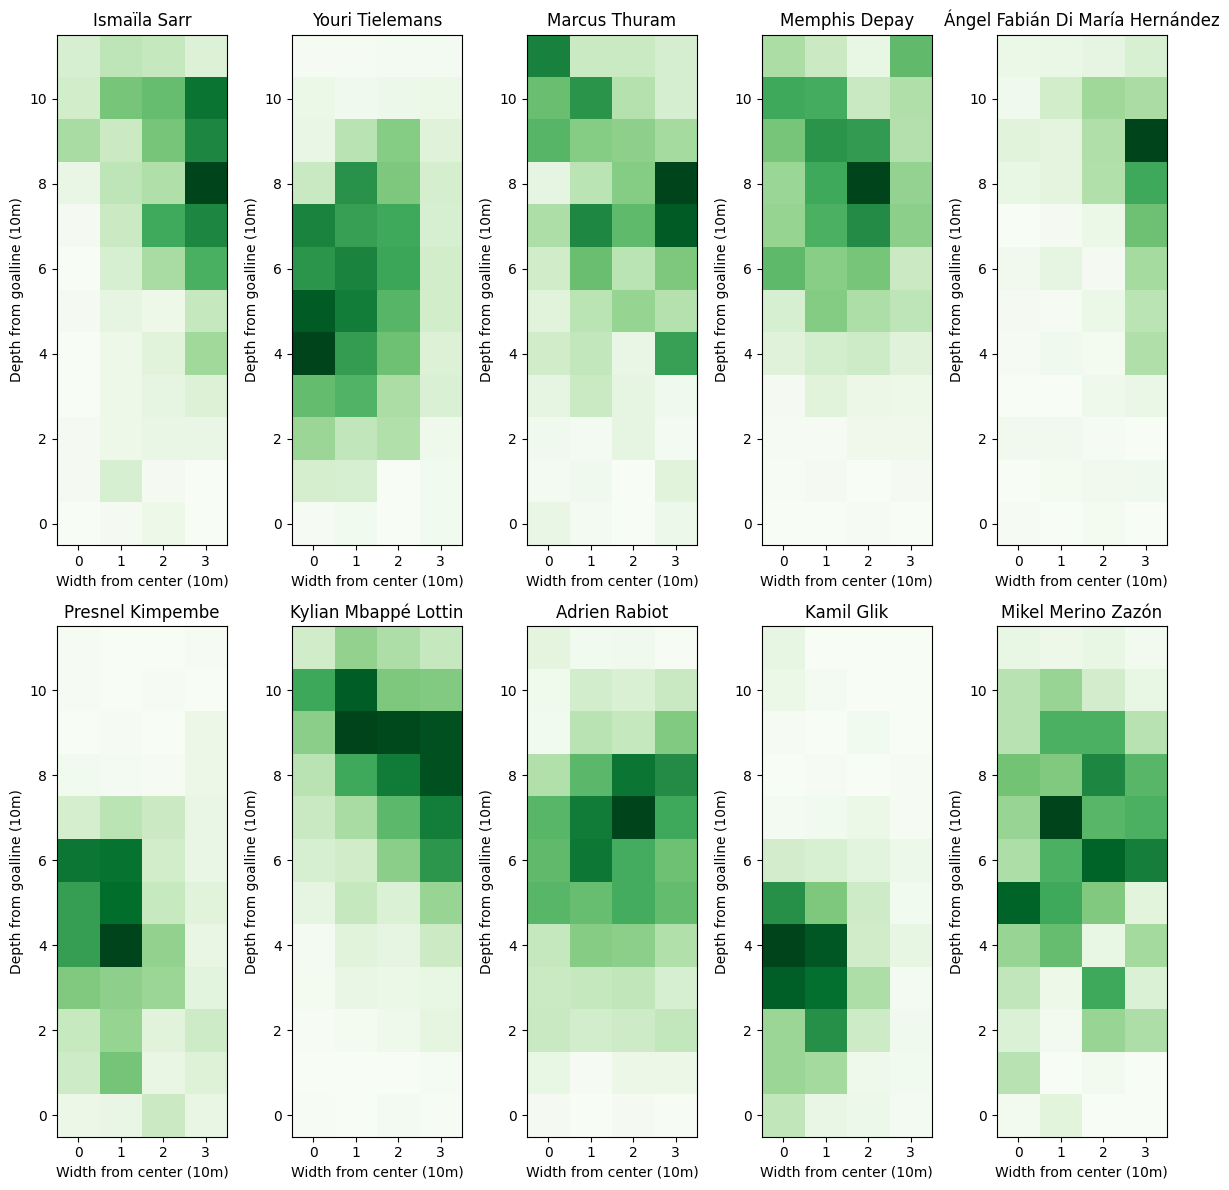

In [10]:
# Number of players to visualize
def visualize_players(heatmaps, ids, file_name = ""):   
    num_players = 10
    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i in range(num_players):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(
            heatmaps[i],
            cmap='Greens',
            origin='lower'
        )
        
        # Get player name safely
        match = player_name[player_name["player_id"] == ids[i]]
        if not match.empty:
            name = match.iloc[0].player_name
        else:
            name = "Unknown"
        
        ax.set_title(name)
        ax.set_xlabel("Width from center (10m)")
        ax.set_ylabel("Depth from goalline (10m)")

    if (file_name == "ret"):
        plt.close(fig)
        return fig
    if (file_name != ""):
        plt.savefig(file_name)
        plt.close(fig)
    else:
        plt.tight_layout()
        plt.show()

visualize_players(heatmaps,ids)

In [11]:
class BottleneckAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(48, 32),  # input 12*4=48 → hidden 32
            nn.ReLU(),
            nn.Linear(32, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.Sigmoid()  # if inputs normalized to [0,1]
        )

    def forward(self, x):
        # Flatten from [B, 1, 12, 4] → [B, 48]
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x = self.decoder(z)
        # Reshape back to [B, 1, 12, 4]
        return x.view(x.size(0), 1, 12, 4)

In [12]:
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = BottleneckAutoencoder(latent_dim=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(50):
    for batch in dataloader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch+1
print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

cpu
Epoch 49, Loss: 0.012152


In [13]:
model.eval()
with torch.no_grad():
    recon = model(inputs).cpu()

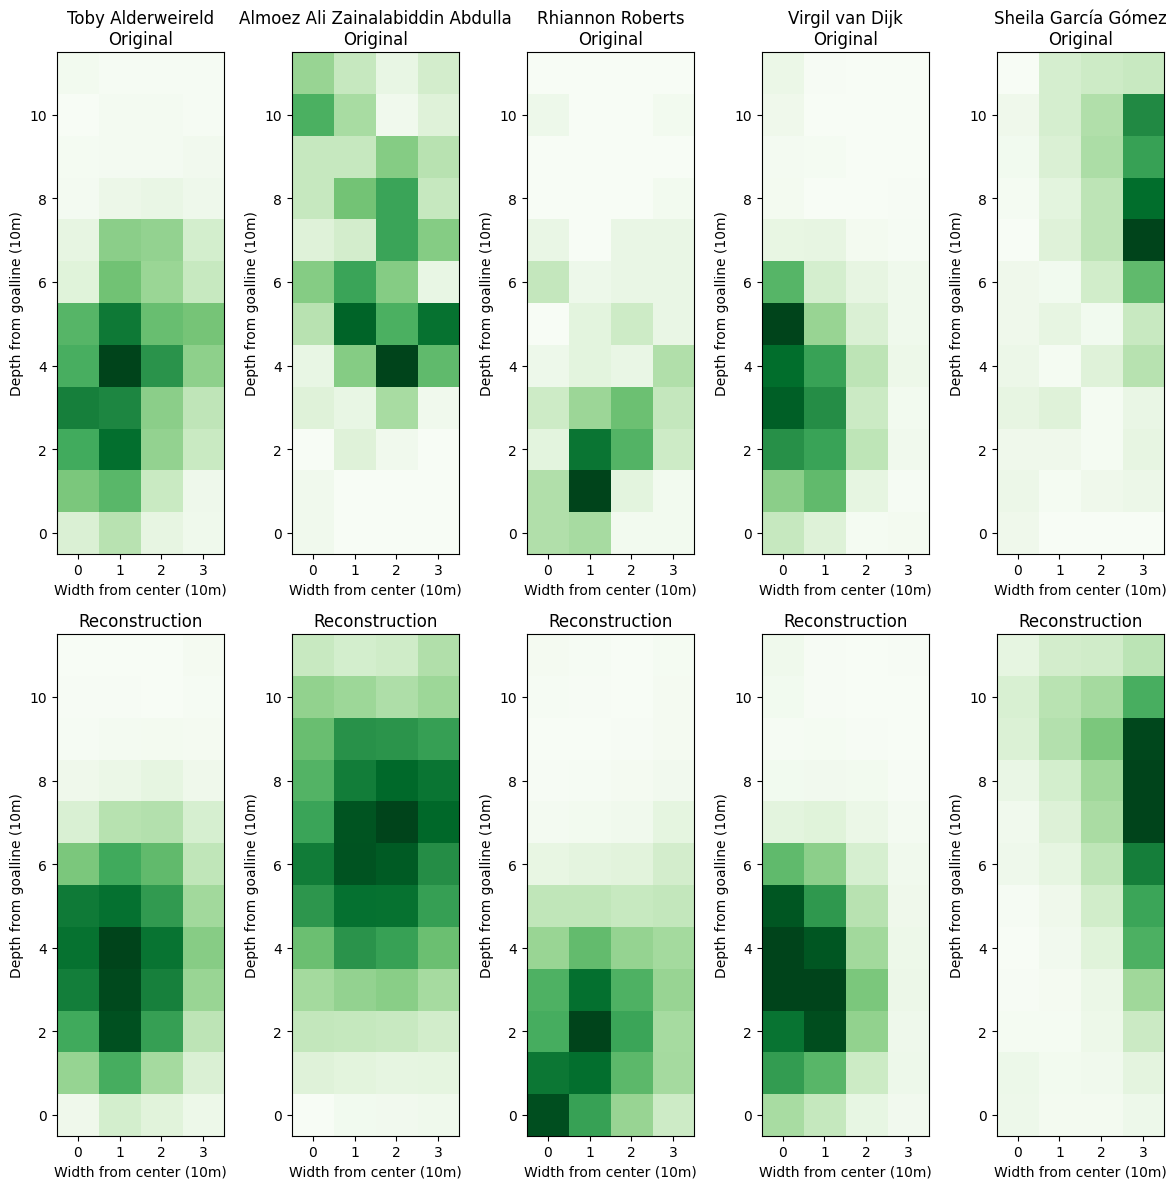

In [14]:
indices = np.random.choice(len(X), size=5, replace=False)

# Get reconstructions
model.eval()
with torch.no_grad():
    inputs = X[indices].to(device)
    recons = model(inputs).cpu()

fig, axes = plt.subplots(2, 5, figsize=(12, 12))

for i in range(5):
    row = 0 if i < 5 else 1   # first 5 originals in row 0, next 5 reconstructions in row 1
    col = i % 5

    axes[0, col].imshow(inputs[i,0].cpu(), cmap='Greens', origin='lower')
    axes[0, col].set_title(f"{player_name[player_name["player_id"] == ids[indices[i]]].iloc[0].player_name}\nOriginal")
    axes[0, col].set_xlabel("Width from center (10m)")
    axes[0, col].set_ylabel("Depth from goalline (10m)")


    axes[1, col].imshow(recons[i,0], cmap='Greens', origin='lower')
    axes[1, col].set_title(f"Reconstruction")
    axes[1, col].set_xlabel("Width from center (10m)")
    axes[1, col].set_ylabel("Depth from goalline (10m)")

plt.tight_layout()
plt.show()


# Player level aggregation


In [15]:
print(", ".join(df_event.columns.to_list()))
df_event['sub_type_name'].unique()
df_event['body_part_name'].unique()
df_event[df_event['type_name'] == "Dribble"]['outcome_name'].unique()
#df_event[df_event['type_name'] == "Shot"]['shot_first_time'].unique()


id, index, period, timestamp, minute, second, possession, duration, match_id, type_id, type_name, possession_team_id, possession_team_name, play_pattern_id, play_pattern_name, team_id, team_name, tactics_formation, player_id, player_name, position_id, position_name, pass_recipient_id, pass_recipient_name, pass_length, pass_angle, pass_height_id, pass_height_name, end_x, end_y, body_part_id, body_part_name, sub_type_id, sub_type_name, x, y, under_pressure, outcome_id, outcome_name, counterpress, out, aerial_won, off_camera, pass_switch, pass_cross, shot_statsbomb_xg, shot_first_time, technique_id, technique_name, goalkeeper_position_id, goalkeeper_position_name, pass_assisted_shot_id, pass_shot_assist, end_z, shot_key_pass_id, injury_stoppage_in_chain, foul_won_defensive, ball_recovery_recovery_failure, foul_committed_advantage, foul_won_advantage, pass_deflected, block_deflection, foul_committed_penalty, foul_won_penalty, foul_committed_card_id, foul_committed_card_name, block_save_blo

array(['Incomplete', 'Complete'], dtype=object)

In [ ]:
df_pressure = df_event.groupby(['player_id'])['under_pressure'].sum().reset_index()
df_pressure.rename(columns={'under_pressure': 'pressure_count'}, inplace=True)

# Count event types 
df_counts = df_event.groupby(['player_id'])['type_name'].value_counts().unstack(fill_value=0).reset_index()
df_counts = df_counts[['player_id', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance', 'Foul Won', 'Foul Committed', 'Goal keeper']].fillna(0)
df_counts.rename({"Goalkeeper", "gk_action"})
df_position_groups = df_event.groupby(['player_id'])['pos_group'].value_counts(normalize=True).unstack(fill_value=0).reset_index()

# Passes

df_event['forward'] = df_event["end_x"] - df_event["x"]
df_event['vertical'] = abs(df_event["y"] - df_event["end_y"])
df_event['width'] = abs(40 - df_event["y"])

df_pass = df_event[(df_event['type_name'] == 'Pass')].groupby(['player_id']).agg(
    all_passes = ('pass_length', 'count'),
    successful_passes = ('outcome_name', lambda x: (x.isin([np.nan, 'Complete', 'Success', 'Success In Play', 'Success To Team'])).sum()),
    avg_pass_length = ('pass_length', 'mean'),
    avg_pass_angle = ('pass_angle', 'mean'),
    median_pass_length = ('pass_length', 'median'),
    longest_forward_pass = ('progression', 'max'),
    pass_switch = ('pass_switch', 'count'),
    pass_cut_back = ('pass_cut_back', 'count'),
    assists = ('pass_goal_assist', 'count'),
    pass_median_start = ('x', 'median'),
    pass_median_end = ('end_x', 'median'),
    pass_median_width_start = ('width', 'median'),
    pass_median_width_end = ('width', 'median'),
).reset_index()
df_pass['pass_success_rate'] = df_pass['successful_passes'] / df_pass['all_passes']
df_pass.fillna(0, inplace=True)



df_pass_types = df_event[df_event['type_name'] == 'Pass'].groupby(['player_id'])['pass_height_name'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pass_types.columns = ['player_id'] + [f'{col.lower().replace(" ", "_")}' for col in df_pass_types.columns[1:]]

# Shots

df_shot = df_event[(df_event['type_name'] == 'Shot')].groupby(['player_id']).agg(
    all_shots = ('id', 'count'),
    shot_mean_length = ('x', 'mean'),
    shot_median_length = ('x', 'median'),
    headers = ('body_part_name', lambda x: (x.isin(['Head'])).sum()),
    extra_shots = ('technique_name', lambda x: (~x.isin(['Normal'])).sum()),
    first_time_shots = ('shot_first_time', 'count'),
    total_xg = ('shot_statsbomb_xg', 'sum'),
    goals = ('outcome_name', lambda x: (x.isin(['Goal'])).sum()),
    shots_on_target = ('outcome_name', lambda x: x.isin(['Goal', 'Saved']).sum())
)
df_shot['headers'] = df_shot['headers'] / df_shot['all_shots']
df_shot['extra_shots'] = df_shot['extra_shots'] / df_shot['all_shots']
df_shot['first_time_shots'] = df_shot['first_time_shots'] / df_shot['all_shots']

df_shot['shot_mean_length'] = df_shot['shot_mean_length'].fillna(
    df_shot['shot_mean_length'].median()
)
df_shot['shot_median_length'] = df_shot['shot_median_length'].fillna(
    df_shot['shot_median_length'].median()
)
df_shot.fillna(0, inplace=True)

# Dribbles
df_dribble = df_event[df_event['type_name'] == 'Dribble'].groupby(['player_id']).agg(
    all_dribbles = ('id', 'count'),
    successful_dribbles_count = ('outcome_name', lambda x: (x.isin(['Complete'])).sum()),
    dribble_start_x = ('x', 'mean')
)
df_dribble['successful_dribbles'] = df_dribble['successful_dribbles_count'] / df_dribble['all_dribbles']

df_dribble.fillna(0, inplace=True)





print(df_event['forward'].max())
print(df_event[df_event['type_name']=='Carry']['end_x'].describe())
print(df_event[df_event['type_name']=='Carry']['forward'].describe())

df_carry = df_event[df_event['type_name'] == 'Carry'].groupby(['player_id']).agg(
    carry_length_forward = ('forward', 'mean'),
    median_carry_length_forward =  ('forward', 'median'),
    carry_length_vertical =  ('vertical', 'mean'),
    median_carry_start = ('x', 'median'),
    median_carry_width = ('width', 'median'),
    median_carry_end = ('end_x', 'median')
)
df_carry.fillna(0, inplace=True)



# Aggregate movement features
df_movement = df_event.groupby(['player_id']).agg(
    total_distance=('distance', 'sum'),
    avg_progression=('progression', 'mean'),
    avg_directness=('directness', 'mean'),
    total_width_change=('width_change', 'sum'),
).reset_index()

# Aggregate pitch zone counts (start zones)
df_pitch_zones = df_event.groupby(['player_id'])['start_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones.columns = ['player_id'] + [f'start_{col.lower().replace(" ", "_")}' for col in df_pitch_zones.columns[1:]]

# Aggregate pitch zone counts (end zones)
df_pitch_zones_end = df_event.groupby(['player_id'])['end_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones_end.columns = ['player_id'] + [f'end_{col.lower().replace(" ", "_")}' for col in df_pitch_zones_end.columns[1:]]


# Pressure & support
df_pressure_support = df_event.groupby(['player_id']).agg(
    avg_opponent_distance = ('opponent_distance', 'mean'),
    avg_teammate_distance = ('teammate_distance', 'mean'),
    avg_opponent_count = ('nearby_opponents', 'mean'),
    avg_teammate_count = ('nearby_teammates', 'mean'),
    avg_advanced_players = ('teammate_behind_ball', 'mean')
    ).reset_index()

# Packing
df_packing = df_event.groupby(['player_id']).agg(
    total_packing=('packing', 'sum')).reset_index()


df_counterpress = df_event.groupby(['player_id'])['counterpress'].sum().reset_index()
df_counterpress.rename(columns={'counterpress': 'counterpress_count'}, inplace=True)


df_aerial_duels = df_event.groupby(['player_id'])['aerial_won'].sum().reset_index()
df_aerial_duels.rename(columns={'aerial_won': 'aerial_duels_won'}, inplace=True)

df_duration = df_event.groupby(['player_id']).agg(avg_duration=('duration', 'mean')).reset_index()


# Merge all aggregated data into a possession-level DataFrame
player_features = df_counts \
    .merge(df_pass, on=['player_id'], how='left') \
    .merge(df_shot, on=['player_id'], how='left') \
    .merge(df_dribble, on=['player_id'], how='left') \
    .merge(df_carry, on=['player_id'], how='left') \
    .merge(df_pressure, on=['player_id'], how='left') \
    .merge(df_movement, on=['player_id'], how='left') \
    .merge(df_pass_types, on=['player_id'], how='left') \
    .merge(df_position_groups, on=['player_id'], how='left') \
    .merge(df_pitch_zones, on=['player_id'], how='left') \
    .merge(df_pitch_zones_end, on=['player_id'], how='left') \
    .merge(df_counterpress[['player_id', 'counterpress_count']], on=['player_id'], how='left') \
    .merge(df_aerial_duels[['player_id', 'aerial_duels_won']], on=['player_id'], how='left') \
    .merge(df_duration[['player_id', 'avg_duration']], on=['player_id'], how='left') \
    .merge(df_pressure_support, on=['player_id'], how='left') \
    .merge(df_packing, on=['player_id'], how='left')

# Fill NaN values with 0 where needed
player_features.fillna(0, inplace=True)
possession_features_original = player_features.copy()


KeyError: "['Goalkeeper'] not in index"

In [ ]:
columns_to_convert = [ 'pass_switch', 'pass_cut_back', 'aerial_duels_won']

for col in columns_to_convert:
    player_features[col] = player_features[col].astype(float)

In [ ]:
player_features.columns

In [ ]:
db = next(get_db())
playing_times = db.query(PlayingTimes).all()
db.close()
df = pd.DataFrame([vars(r) for r in playing_times]).drop(columns="_sa_instance_state")
df
total_minutes_df = df.groupby(["player_id"])["minutes"].sum().reset_index()
total_minutes_df
names_df = df.groupby(["player_id"])["player_name"].min().reset_index()
player_features = player_features.merge(total_minutes_df, on=['player_id'], how='left')
player_features = player_features.merge(names_df, on=['player_id'], how='left')

In [ ]:
player_features.to_excel('../../excel/player_features.xlsx', index=False)

# Normalization

In [ ]:
player_features = pd.read_excel('../../excel/player_features.xlsx')
player_features = player_features[player_features['minutes'] > 500]
player_features.reset_index(drop=True, inplace=True)

In [ ]:
# Wide Focus = Width-related features (Summing all start & end width-related positions)
player_features["wide_focus"] = (
    player_features["start_attacking_left"] +
    player_features["start_attacking_right"] +
    player_features["start_middle_left"] +
    player_features["start_middle_right"] +
    player_features["start_defensive_left"] +
    player_features["start_defensive_right"] +
    player_features["end_attacking_left"] +
    player_features["end_attacking_right"] +
    player_features["end_middle_left"] +
    player_features["end_middle_right"] +
    player_features["end_defensive_left"] +
    player_features["end_defensive_right"]
)

player_features["defensive_start"] = (
    player_features["start_defensive_left"] +
    player_features["start_defensive_right"] +
    player_features["start_defensive_center"]
)
player_features["middle_start"] = (
    player_features["start_middle_left"] +
    player_features["start_middle_right"] +
    player_features["start_middle_center"]
)
player_features["attacking_start"] = (
    player_features["start_attacking_left"] +
    player_features["start_attacking_right"] +
    player_features["start_attacking_center"]
)

In [ ]:

per90_columns = ['Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure',
       'Block', 'Ball Recovery', 'Interception', 'Clearance', 'Foul Won',
       'Foul Committed', 'pass_switch', 'pass_cut_back','total_xg',
       'successful_dribbles_count', 'pressure_count',
       'total_distance', 'total_width_change', 'counterpress_count',
       'aerial_duels_won', 'total_packing', 'wide_focus',
       'shots_on_target','assists','goals']
player_features[per90_columns] = player_features[per90_columns].div(player_features["minutes"], axis=0) * 90

player_features.to_excel('../../excel/player_features_p90.xlsx', index=False)

In [ ]:

# Dropping original columns to avoid redundancy
features_to_drop = [
    # Wide Focus Components
    "start_attacking_left", "start_attacking_right", "start_middle_left", "start_middle_right", "start_defensive_left", "start_defensive_right",
    "start_attacking_center", "start_defensive_center", "start_middle_center",
    "end_attacking_left", "end_attacking_right", "end_middle_left", "end_middle_right", "end_defensive_left", "end_defensive_right",
    "end_attacking_center", "end_defensive_center", "end_middle_center",
    'all_passes', 'successful_passes','all_shots', 'all_dribbles',
    
    'pass_success_rate','extra_shots','first_time_shots','shots_on_target','assists','goals','player_id', 'successful_dribbles_count','successful_dribbles','defensive_start', 'middle_start', 'attacking_start'
    ,'Carry', 'shot_mean_length','avg_pass_length','median_carry_end', 'total_packing', 'total_width_change'
    # Highly Correlated Features
    #"ground_pass","total_width_change", "successful_passes", "pressure_count","all_passes", "total_distance",
    #"total_width_change", "total_packing", "total_duration", "wide_focus", "defensive_intensity", "on_ball_actions", "defensive_actions"
    # 'avg_directness','low_pass', 'Shot',
    #   'pass_switch', 'pass_cut_back', 'aerial_duels_won', 'defensive_start', 'middle_start'
]
player_features_dr = player_features.drop(columns=features_to_drop)

In [ ]:
non_numeric_cols = ['player_id', 'player_name', 'minutes']

df_numeric = player_features_dr.drop(columns=non_numeric_cols, errors='ignore')
corr_matrix = df_numeric.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

corr_matrix = df_numeric.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > 0.80
]

if high_corr_pairs:
    print("Highly correlated feature pairs (correlation > 0.80):")
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1} and {col2}: {corr_value:.2f}")
else:
    print("No feature pairs with correlation greater than 0.80.")


In [ ]:
model.eval()
latent_list = []

with torch.no_grad():
    for hm in heatmaps:
        x = torch.tensor(hm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,6,4]
        z = model.encoder(x.view(1, -1))  # [1, latent_dim]
        latent_list.append(z.squeeze(0).numpy())

latent_array = np.vstack(latent_list)  # shape: [N, latent_dim]

In [ ]:
latent_df = pd.DataFrame(latent_array, columns=[f"latent_{i}" for i in range(latent_array.shape[1])])

df_numeric = pd.concat([df_numeric.reset_index(drop=True), latent_df], axis=1)

In [ ]:
position_columns = ['Goalkeeper','Center Back', 'Wide Back', 'Center Midfield', 'Wide Midfield', 'Striker']

In [ ]:
corr_matrix = df_numeric.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

In [ ]:
def closure(arr):
    """L1-normalize rows so they sum to 1 (inplace-safe)."""
    arr = np.asarray(arr, dtype=float)
    row_sums = arr.sum(axis=1, keepdims=True)
    # avoid division by zero
    row_sums[row_sums == 0] = 1.0
    return arr / row_sums

def clr_transform(arr, pseudocount=1e-6):
    """Apply CLR row-wise. arr must be positive. Returns array of same shape."""
    arr = np.asarray(arr, dtype=float) + pseudocount
    logA = np.log(arr)
    gm = logA.mean(axis=1, keepdims=True)
    return logA - gm

def centered_log_ratio(player_df):
    part_cols = [c for c in player_df.columns if c.startswith("latent_")]
    stat_cols = [c for c in player_df.columns if not c.startswith("latent_") and c not in position_columns]
    pos_comp = closure(player_df[position_columns].values)

    pos_clr = clr_transform(pos_comp, pseudocount=1e-6)
    scaler = StandardScaler()
    pos_clr = scaler.fit_transform(pos_clr)
    part_scaled = scaler.fit_transform(player_df[part_cols])
    scaler2 = StandardScaler()
    stat_scaled = scaler2.fit_transform(player_df[stat_cols])
    # optional: weight groups (example: make positions twice as important)
    pos_weight = 2
    part_weight = 1.8
    stat_weight = 0.8
    part_scaled = np.clip(part_scaled, -3, 3)
    stat_scaled = np.clip(stat_scaled, -3, 3)
    pos_clr *= pos_weight
    part_scaled *= part_weight
    stat_scaled *= stat_weight

    #print(stat_cols)
    #print(stat_scaled)
    # --- concat, scale, cluster ---
    X = np.hstack([pos_clr, part_scaled, stat_scaled])
    return X


In [ ]:
from sklearn.decomposition import PCA

scaled_features = centered_log_ratio(df_numeric)
part_cols = [c for c in df_numeric.columns if c.startswith("latent_")]
stat_cols = [c for c in df_numeric.columns if not c.startswith("latent_") and c not in position_columns]
correct_order = position_columns + part_cols + stat_cols

pca_df = pd.DataFrame(scaled_features, columns=correct_order)
pd.set_option('display.max_rows', None)
#print(pca_df.std())
pd.reset_option('display.max_rows')

position_indices = [df_numeric.columns.get_loc(c) for c in position_columns]

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares

max_cluster_test = 10

for i in range(2, max_cluster_test):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_cluster_test), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()


# Silhouette Score to support the elbow method
silhouette_scores = []
for n_clusters in range(2, max_cluster_test):
    kmeans = KMeans(
    n_clusters=n_clusters,
    init='k-means++',  
    n_init=50,
    max_iter=500,
    random_state=42
    )
    cluster_labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_cluster_test), silhouette_scores, marker='s', linestyle='-', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.grid()
plt.show()

# Apply K-Means with the optimal number of clusters (let's assume 4 based on elbow/silhouette)
optimal_clusters = 6  # Adjust this based on your elbow/silhouette plot results
kmeans_final = KMeans(
    n_clusters=optimal_clusters,
    init='k-means++',  
    n_init=50,
    max_iter=500,
    random_state=42
)

#pca_df = pd.DataFrame(scaled_features, columns=df_numeric.columns)

pca_df.to_csv('../../excel/pca_df.csv', index=False)
#pca_df = df_numeric.copy()
# Predict clusters
pca_df['Cluster'] = kmeans_final.fit_predict(pca_df)



# Analyze the average feature values per cluster (to profile playing styles)
cluster_profiles = pd.concat([pca_df, df_numeric.reset_index(drop=True)], axis=1)
cluster_summary = cluster_profiles.groupby('Cluster').mean()

In [ ]:
player_features["Cluster"] = pca_df['Cluster']

player_features.columns

#assert (player_features.index == pca_df.index).all(), "Row order changed!"

names_unique = df_event.loc[:,['player_id']].drop_duplicates(subset=["player_id"]).reset_index()
player_features_with_name = player_features.merge(names_unique, on="player_id", how="left")
df_player = pca_df.copy()
df_player["player_name"] = player_features_with_name["player_name"] 
#df_player.to_csv('../../excel/pca_df.csv', index=False)

In [ ]:
cluster_means = player_features.groupby('Cluster')[position_columns].mean()
cluster_to_position = cluster_means.idxmax(axis=1).to_dict()

player_features_with_name['Cluster'] = player_features_with_name['Cluster'].map(cluster_to_position)

cluster_means

In [ ]:
# Create a new column for subclusters
pca_df['SubCluster'] = -1  # placeholder

all_centers = []

for cluster_id in np.sort(pca_df['Cluster'].unique()):
    # Select data for this cluster
    cluster_data = pca_df[pca_df['Cluster'] == cluster_id].drop(columns=['Cluster', 'SubCluster'])
    cluster_data = cluster_data.drop(columns=position_columns)
    #if cluster_id == 5:
    #    cluster_data = cluster_data.loc[:, ["Pass","Carry","avg_pass_length", "carry_length_forward", "median_carry_start", "avg_progression", "avg_directness"]]
    scaler = StandardScaler()
    cluster_data = pd.DataFrame(scaler.fit_transform(cluster_data), columns=cluster_data.columns)

    # Decide how many subclusters you want
    print(cluster_data.shape)
    n_subclusters = n_subclusters = min(3, len(cluster_data)//30)  # or choose dynamically based on len(cluster_data)

    print(f'{n_subclusters} for cluster {cluster_to_position[cluster_id]}')
    
    # Only cluster if there are enough points
    if len(cluster_data) > n_subclusters:
        sub_kmeans = KMeans(
            n_clusters=n_subclusters,
            init='k-means++',  
            n_init=50,
            max_iter=500,
            random_state=42
        )
        pca_df.loc[pca_df['Cluster'] == cluster_id, 'SubCluster'] = sub_kmeans.fit_predict(cluster_data)
        centers = pd.DataFrame(
            sub_kmeans.cluster_centers_,
            columns=cluster_data.columns
        )
        all_centers.append(centers)
        centers.to_csv(f'../../excel/centers_{cluster_to_position[cluster_id]}.csv')

        feature_variance = centers.var(axis=0)

        # Normalize to sum to 1 to get relative importance
        feature_importance = feature_variance / feature_variance.sum()

        # Create a DataFrame for display
        importance_df = pd.DataFrame({
            'Feature': feature_importance.index,
            'Importance': feature_importance.values
        }).sort_values(by='Importance', ascending=False)
        top_features = importance_df[~importance_df["Feature"].str.contains("latent_")].head(20)
        print(top_features)
        top_feature_names = top_features["Feature"].tolist()
        centers_long = centers.melt(ignore_index=False, var_name="Feature", value_name="Value")
        centers_long = centers_long.reset_index().rename(columns={"index": "Cluster"})

        
        centers_top10 = centers[top_feature_names]
        
        plt.figure(figsize=(20, 6))
        sns.barplot(data=centers_long, x="Feature", y="Value", hue="Cluster")

        plt.title("Cluster Centers — Feature Importance (Normalized)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(16, 6))
        sns.heatmap(
            centers_top10,
            cmap="viridis",       # or any colormap you like
            annot=True,           # show numeric values
            fmt=".2f",            # format annotation
            linewidths=0.5,       # grid lines between cells
            cbar_kws={"label": "Cluster center value"}  # colorbar label
        )

        plt.title("Cluster/Subcluster Centers — Feature Values")
        plt.xlabel("Features")
        plt.ylabel("SubCluster")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        


    else:
        # If too few points, assign all to one subcluster (e.g., 0)
        pca_df.loc[pca_df['Cluster'] == cluster_id, 'SubCluster'] = 0

In [ ]:
player_features["SubCluster"] = pca_df['SubCluster']
player_features_with_name["SubCluster"] = pca_df['SubCluster']

In [ ]:
player_features_with_name.groupby(["Cluster", "SubCluster"]).agg(
    minutes_mean = ("minutes", "mean"),
    minutes_median = ("minutes", "median"),
    minutes_sum  = ("minutes", "sum"),
    count        = ("player_id", "count")
)

In [ ]:
from requests import Session
from sqlalchemy import delete
from sql_schemas import PlayerStats


def init_player_stats(db: Session, df, tableClass=PlayerStats):
    # 1️⃣ Clear existing table
    db.execute(delete(tableClass))
    db.commit()

    # 2️⃣ Rename DataFrame columns to match ORM (adjust names if needed)
    df = df.rename(columns={
        "player_id": "id",
        "Pass": "pass_90",
        "Carry": "carry_90",
        "Dribble": "dribble_90",
        "Shot": "shot_90",
        "Duel": "duel_90",
        "Pressure": "pressure_90",
        "Block": "block_90",
        "Ball Recovery": "ball_recovery_90",
        "Interception": "interception_90",
        "Clearance": "clearance_90",
        "Foul Won": "foul_won_90",
        "Foul Committed": "foul_commited_90",
        "shot_mean_length": "average_shot_length",
        "headers": "header_percent",
        "total_xg": "xg_90",
        "successful_dribbles": "dribble_percent",
        "dribble_start_x": "average_dribble_start_x",
        "ground_pass": "ground_pass_percent",
        "low_pass": "low_pass_percent",
        "high_pass": "high_pass_percent",
        "Goalkeeper": "goalkeeper",
        "Center Back": "center_back",
        "Wide Back": "wide_back",
        "Center Midfield": "center_midfielder",
        "Wide Midfield": "wide_midfielder",
        "Striker": "striker",
        "defensive_start": "defensive_start_percent",
        "middle_start": "middle_start_percent",
        "attacking_start": "attacking_start_percent",
        "pass_success_rate":"pass_success_rate_percent",
        "extra_shots":"extra_shots_percent",
        "first_time_shots":"first_time_shots_percent" ,
        "shots_on_target":"shots_on_target_percent",
        "assists":"assists_90",
        "goals":"goals_90",
        "SubCluster" : "cluster"
    })

    orm_columns = set(c.name for c in tableClass.__table__.columns)

    df_filtered = df[[col for col in df.columns if col in orm_columns]]

    new_rows = [
        tableClass(**p)
        for p in df_filtered.to_dict(orient="records")
    ]
    db.bulk_save_objects(new_rows)
    db.commit()

In [ ]:
player_features_with_name.to_excel('../../excel/player_features_results.xlsx', index=False)
init_player_stats(db, player_features_with_name)


In [ ]:
cluster_counts = player_features_with_name["SubCluster"].value_counts().sort_index()
print(cluster_counts)

In [ ]:
player_features_with_name.loc[:, ["Pass"]].describe()
player_features_with_name[player_features_with_name["Shot"]==0]['minutes']

In [ ]:
mapping = {
    ('Goalkeeper', 0): 'Line Keeper',
    ('Goalkeeper', 1): 'Ball Playing Keeper',
    ('Center Back', 0): 'Sweeper',
    ('Center Back', 1): 'Stopper',
    ('Center Back', 2): 'Ball Playing Defender',
    ('Center Midfield', 0): 'Box To Box Midfielder',
    ('Center Midfield', 1): 'Advanced Playmaker',
    ('Center Midfield', 2): 'Holding Midfielder',
    ('Wide Back', 0): 'Inverted Full Back',
    ('Wide Back', 1): 'Wing Back',
    ('Wide Back', 2): 'Full Back',
    ('Wide Midfield', 0): 'Winger',
    ('Wide Midfield', 1): 'Inside Forward',
    ('Wide Midfield', 2): 'Wide Playmaker',
    ('Striker', 0): 'Target Man',
    ('Striker', 1): 'Mobile Striker',
    ('Striker', 2): 'Second Striker'
}
#player_features_with_name['SubCluster'] = player_features_with_name.apply(lambda row: mapping.get((row['Cluster'], row['SubCluster'])), axis=1)

In [ ]:
centers = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=correct_order
)
centers_long = centers.melt(ignore_index=False, var_name="Feature", value_name="Value")
centers_long = centers_long.reset_index().rename(columns={"index": "Cluster"})

plt.figure(figsize=(20, 6))
sns.barplot(data=centers_long, x="Feature", y="Value", hue="Cluster")

plt.title("Cluster Centers — Feature Importance (Normalized)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
centers

In [ ]:
df_numeric_cluster = df_numeric.copy()
df_numeric_cluster["Cluster"] = pca_df["Cluster"]
cluster_centers_original = (
    df_numeric_cluster.groupby("Cluster")[[x for x in pca_df.columns if "Cluster" not in x]]
      .mean()
      .reset_index()
)

print(cluster_centers_original)

In [ ]:
def visualize_cluster(j):
    for k in player_features_with_name["SubCluster"].unique():
        cluster_ids = player_features_with_name.loc[
            (player_features_with_name["Cluster"] == j) & (player_features_with_name["SubCluster"] == k), 
            "player_id"
        ].unique()
        if len(cluster_ids)>10:
            filtered_ids = [i for i in ids if i in cluster_ids]
            filtered_heatmaps = [
                heatmap for heatmap, pid in zip(heatmaps, ids) if pid in cluster_ids
            ]
            print(f"{j},{k}")
            plot = visualize_players(filtered_heatmaps, filtered_ids, "ret")

In [ ]:
highlight_features_list = ["Pass", "pass_median_start","pass_median_width_start", "median_pass_length", "Carry", "Interception","counterpress_count", "avg_directness"] 
grouped = player_features_with_name.loc[:, highlight_features_list + ["Cluster", "SubCluster"]].groupby(["Cluster", "SubCluster"])

# Select only numeric feature columns
numeric_cols = player_features_with_name.select_dtypes(include='number').columns

stats_df = (
    player_features_with_name
        .groupby(["Cluster", "SubCluster"])[highlight_features_list]
        .agg(['mean'])
)

# Flatten multi-index column names
stats_df.columns = ['_'.join(col) for col in stats_df.columns]

# Save to CSV
stats_df.to_csv("cluster_subcluster_stats.csv")

In [ ]:
for j in player_features_with_name["Cluster"].unique():
    for k in player_features_with_name["SubCluster"].unique():
        cluster_ids = player_features_with_name.loc[
            (player_features_with_name["Cluster"] == j) & (player_features_with_name["SubCluster"] == k), 
            "player_id"
        ].unique()
        if len(cluster_ids)>10:
            filtered_ids = [i for i in ids if i in cluster_ids]
            filtered_heatmaps = [
                heatmap for heatmap, pid in zip(heatmaps, ids) if pid in cluster_ids
            ]
            print(f"{j},{k}")

            visualize_players(filtered_heatmaps, filtered_ids, f"../../plots/players_cluster_{j}_{k}.png")
            

In [ ]:
a = player_features_with_name.loc[:,["Cluster", 'avg_pass_length', 'wide_focus', 'attacking_start','total_xg']].groupby(["Cluster"]).describe().T
a

In [ ]:
player_features['Cluster'] = pca_df['Cluster']
df_event_with_clusters = df_event.merge(
    player_features[['player_id', 'Cluster']],
    on=['player_id'],
    how='left')
df_event_with_clusters

In [ ]:

def visualize_players2(heatmaps, ids):
    num_players = 5
    rows, cols = 1, 5

    fig, axes = plt.subplots(rows, cols, figsize=(10, 4))

    for i in range(num_players):
        r, c = divmod(i, cols)
        ax = axes[c]

        ax.imshow(heatmaps[i], cmap='Greens', origin='lower')

        # Title
        match = player_name[player_name["player_id"] == ids[i]]
        name = match.iloc[0].player_name if not match.empty else "Unknown"
        ax.set_title(name)

        #ax.axis("off")

    fig.tight_layout()

    # --- Convert figure to image array ---
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))

    plt.close(fig)  # avoid drawing

    return img

In [ ]:
def format_title(title, max_length=20):
    if len(title) > max_length:
        # Find indices of all spaces
        space_indices = [i for i, c in enumerate(title) if c == " "]
        if len(space_indices) >= 2:
            split_idx = space_indices[1]
            title = title[:split_idx] + "\n" + title[split_idx+1:]
        else:
            # Fallback: break at first space
            title = title.replace(" ", "\n", 1)
    return title


In [ ]:
for j in player_features_with_name["Cluster"].unique():

    images = []
    titles = []

    for k in player_features_with_name["SubCluster"].unique():

        cluster_ids = player_features_with_name.loc[
            (player_features_with_name["Cluster"] == j) &
            (player_features_with_name["SubCluster"] == k)
        ].sort_values(by="minutes", ascending=False).head(10)["player_id"].unique()

        if len(cluster_ids) <= 10:
            continue

        filtered_heatmaps = [
            hm for hm, pid in zip(heatmaps, ids) if pid in cluster_ids
        ]
        filtered_ids = [pid for pid in ids if pid in cluster_ids]

        img = visualize_players2(filtered_heatmaps, filtered_ids)

        images.append(img)
        titles.append(f"SubCluster {k}")

    if not images:
        continue

    # ---- Build final stacked plot ----
    n = len(images)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n))

    if n == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(format_title(title))
        ax.axis("off")

    fig.tight_layout()
    fig.savefig(f"../../plots/cluster_{j}_combined.png", dpi=150)
    plt.close(fig)
